Importing Libraries

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import pickle

**Image Preprocessing**


Loading Test and Train Data

In [6]:
trainingpath=r"/content/drive/MyDrive/dataset/spiral/training"
testingpath=r"/content/drive/MyDrive/dataset/spiral/testing"


Quantify Image

In [7]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), 
                           cells_per_block=(2, 2),
                           transform_sqrt=True, 
                           block_norm="L1")
    return features


Feature data and associated class labels

In [8]:
def load_split(path):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))

        image=cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        features = quantify_image(image)

        data.append(features)
        labels.append(label)

    return (np.array(data), np.array(labels))

Load Train Data and Test Data

In [9]:
print("[INFO] loading data...")
(X_train, y_train) = load_split(trainingpath)
(X_test, y_test) = load_split(testingpath)

[INFO] loading data...


In [10]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print(X_train.shape,y_train.shape)

(72, 12996) (72,)


**Model** **Building**

In [11]:
print("[INFO] training model")
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)


[INFO] training model


RandomForestClassifier()

Testing The Model


In [12]:
testingpath=list(paths.list_images(testingpath))
idxs=np.arange(0,len(testingpath))
idxs=np.random.choice(idxs,size=(25,),replace=False)
images=[]

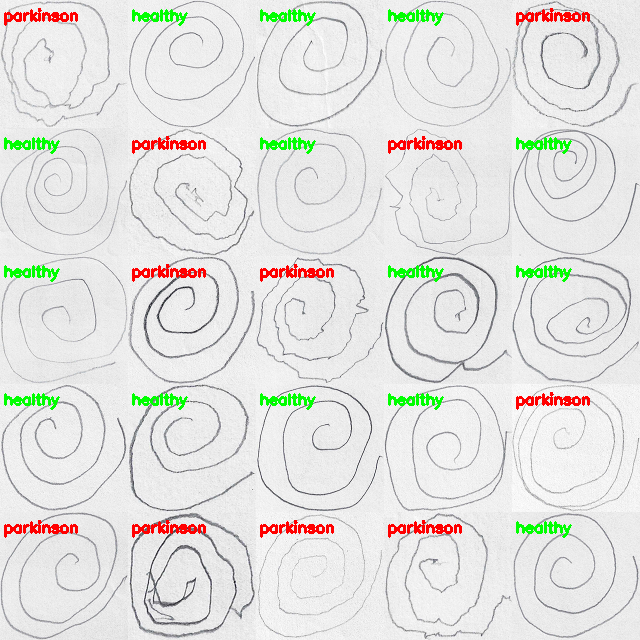

In [13]:
for i in idxs:
    image=cv2.imread(testingpath[i])
    output=image.copy()
        
    # load the input image,convert to grayscale and resize
    
    output=cv2.resize(output,(128,128))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image=cv2.resize(image,(200,200))
    image=cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    #quantify the image and make predictions based on the  extracted feature using last trained random forest
    features=quantify_image(image)
    preds=model.predict([features])
    label=label_encoder.inverse_transform(preds)[0]
    #the set of output images
    if label=="healthy":
        color=(0,255,0)
    else:
        color=(0,0,255)
        
    cv2.putText(output,label,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    images.append(output)

#creating a montage
montage=build_montages(images,(128,128),(5,5))[0]
cv2_imshow(montage)

Model Evaluation and Performance metrics

In [14]:
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions).flatten()
print(cm)
(tn, fp, fn, tp) = cm
accuracy = (tp + tn) / float(cm.sum())
print(accuracy)

[14  1  3 12]
0.8666666666666667


In [20]:
from sklearn import metrics
recall_sensitivity = metrics.recall_score(y_test, predictions,pos_label=0)
recall_specificity = metrics.recall_score(y_test, predictions, pos_label=0)
recall_sensitivity, recall_specificity

(0.9333333333333333, 0.9333333333333333)

In [22]:
precision_positive = metrics.precision_score(y_test, predictions, pos_label=1)
precision_negative = metrics.precision_score(y_test, predictions, pos_label=0)
precision_positive,precision_negative

(0.9230769230769231, 0.8235294117647058)

In [23]:
f1_positive = metrics.f1_score(y_test, predictions, pos_label=1)
f1_negative = metrics.f1_score(y_test, predictions, pos_label=0)
f1_positive, f1_negative 

(0.8571428571428571, 0.8749999999999999)

In [25]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.92      0.80      0.86        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



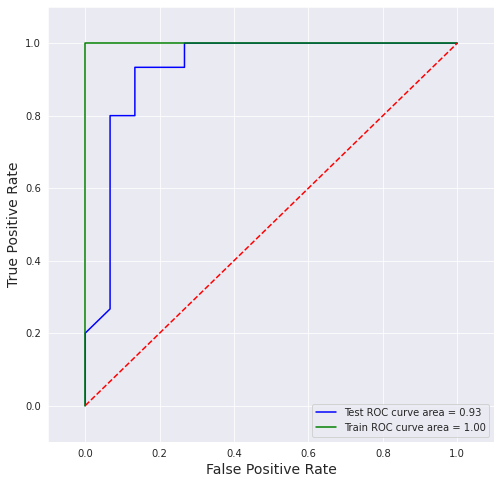

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
preds_train = model.predict(X_train)
 # calculate prediction probability
prob_train = np.squeeze(model.predict_proba(X_train)[:,1].reshape(1,-1))
prob_test = np.squeeze(model.predict_proba(X_test)[:,1].reshape(1,-1))
 # false positive rate, true positive rate, thresholds
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, prob_test)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_train, prob_train)
 # auc score
auc1 = metrics.auc(fpr1, tpr1)
auc2 = metrics.auc(fpr2, tpr2)
plt.figure(figsize=(8,8))
 # plot auc 
plt.plot(fpr1, tpr1, color='blue', label='Test ROC curve area = %0.2f'%auc1)
plt.plot(fpr2, tpr2, color='green', label='Train ROC curve area = %0.2f'%auc2)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='lower right')
plt.show() 


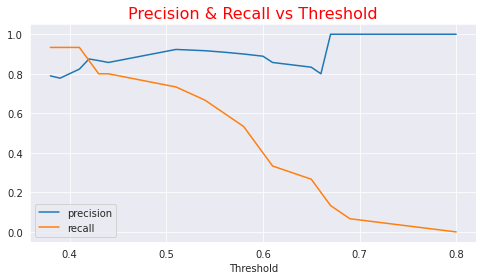

In [27]:
pre, rec, thr = metrics.precision_recall_curve(y_test, prob_test)
plt.figure(figsize=(8,4))
plt.plot(thr, pre[:-1], label='precision')
plt.plot(thr, rec[1:], label='recall')
plt.xlabel('Threshold')
plt.title('Precision & Recall vs Threshold', c='r', size=16)
plt.legend()
plt.show() 

In [28]:
cross_entropy_loss = metrics.log_loss(y_test, prob_test)
cross_entropy_loss 

0.4812316995495089

In [30]:
hamming_loss = metrics.hamming_loss(y_test, predictions)
hamming_loss

0.13333333333333333

In [32]:
jaccard = metrics.jaccard_score(y_test, predictions)
jaccard 

0.75